<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [475]:
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys

from datetime import timedelta, datetime, date

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor


import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression

import json
import matplotlib.pyplot as plt
import seaborn as sns


warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None) #отображение всех столбцов датасета

In [476]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [477]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [478]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [479]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
#  Функция по сравнению дата-сетов (найдена на каггле)
def check_df_1vs2(d_df1,d_df2):
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_dict['# unique_train'] = d_df1.nunique().values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_dict2['# unique_test'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_insert = pd.DataFrame(columns=['< - >'])
    
    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
#    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)
        if temp_df3['# unique_test'][i]>0 and temp_df3['# unique_train'][i]/temp_df3['# unique_test'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)
    
def print_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

# Визуализация числовых данных
def graph_num(col, df, size=6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle('Histogram and boxplot for {0}'.format(col), fontsize=20)
    g1.hist(df[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8, color='green')  # гистограмма
    g2.boxplot(df[col], vert=False)  # выбросы
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.show

# Визуализация корреляции числовых признаков между собой
def jointplot_f(col_num, df):
    pairs = list(itertools.combinations(col_num, 2))
    for pair in pairs:
        sns.jointplot(x=pair[0], y=pair[1], data=df)
    return

# Статистические данные по выбросам
def statistic(col, df):
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l = perc25 - 1.5*IQR
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col, IQR),
          "Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(
        df[df[col] > r][col].count()+df[df[col] < l][col].count()))

# Setup

In [484]:
VERSION    = 16
DIR_TRAIN1  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TRAIN  = '../input/auto-ru-26-05-2021-new/' # подключил к ноутбуку внешний датасет
DIR_TRAIN_CUR  = '../input/exchange-rate/'

DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [485]:
!ls '../input'

auto-ru-26-05-2021-new	parsing-all-moscow-auto-ru-09-09-2020
exchange-rate		sf-dst-car-price-prediction


In [486]:
train = pd.read_csv(DIR_TRAIN+'auto_ru_26_05_2021.csv') # датасет для обучения модели
train_old = pd.read_csv(DIR_TRAIN1+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
exchange_rate = pd.read_csv(DIR_TRAIN_CUR+'exchange_currency.csv') # курс доллара

test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [487]:
exchange_rate

,year,rate
0,1999,24.61
1,2000,28.12
2,2001,29.17
3,2002,31.35
4,2003,30.69
5,2004,28.81
6,2005,28.29
7,2006,27.19
8,2007,25.58
9,2008,24.86


In [488]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68518 entries, 0 to 68517
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Engine               68518 non-null  object 
 1   bodyType             68518 non-null  object 
 2   car_url              68518 non-null  object 
 3   color                68518 non-null  object 
 4   complectation_dict   68518 non-null  object 
 5   equipment_dict       68518 non-null  object 
 6   mileage              68518 non-null  float64
 7   model_info           68518 non-null  object 
 8   model_name           68518 non-null  object 
 9   parsing_unixtime     68518 non-null  float64
 10  price                68518 non-null  int64  
 11  productionDate       68518 non-null  float64
 12  super_gen            68518 non-null  object 
 13  title                68518 non-null  object 
 14  vehicleTransmission  68518 non-null  object 
 15  vendor               68518 non-null 

In [490]:
'''train['price'] = train['price'].str.replace('\xa0', '')
train['price'] = train['price'].str.replace('₽', '')
train['price'] = train['price'].str.replace('от ', '').astype(int)
train['price'].isna().sum()'''

"train['price'] = train['price'].str.replace('\xa0', '')\ntrain['price'] = train['price'].str.replace('₽', '')\ntrain['price'] = train['price'].str.replace('от ', '').astype(int)\ntrain['price'].isna().sum()"

In [491]:
train.head(5)

,Engine,bodyType,car_url,color,complectation_dict,equipment_dict,mileage,model_info,model_name,parsing_unixtime,price,productionDate,super_gen,title,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Пробег,Руль,Состояние,Таможня,Владение,fuelType,enginePower,engineDisplacement,brand,numberOfDoors
0,4.6 л / 125 л.с. / Бензин,седан,https://auto.ru/cars/used/sale/packard/clipper...,чёрный,"{""id"":""0""}","{""condition"":true}",74000.0,"{""code"":""CLIPPER"",""name"":""Clipper"",""ru_name"":""...",CLIPPER,1.622017e+09,3900000,1942.0,"{""id"":""20660716"",""year_from"":1941,""year_to"":19...",Packard Clipper,механическая,AMERICAN,1 владелец,Оригинал,задний,74 000 км,Левый,Не требует ремонта,Растаможен,NaN,Бензин,125 л.с.,4.6 л,Packard,4
1,3.3 л / 54 л.с. / Бензин,внедорожник открытый,https://auto.ru/cars/used/sale/gaz/67/11015308...,зелёный,"{""id"":""0""}","{""condition"":true}",10000.0,"{""code"":""67"",""name"":""ГАЗ 67"",""ru_name"":""67"",""m...",67,1.622017e+09,1490000,1943.0,"{""id"":""20661413"",""year_from"":1943,""year_to"":19...",ГАЗ ГАЗ 67,механическая,RUSSIAN,3 или более,Дубликат,полный,10 000 км,Левый,Не требует ремонта,Растаможен,NaN,Бензин,54 л.с.,3.3 л,ГАЗ,4
2,3.3 л / 54 л.с. / Бензин,внедорожник открытый,https://auto.ru/cars/used/sale/gaz/67/10866273...,зелёный,"{""id"":""0""}","{""engine-proof"":true,""turnbuckle"":true,""spare-...",100.0,"{""code"":""67"",""name"":""ГАЗ 67"",""ru_name"":""67"",""m...",67,1.622017e+09,395000,1943.0,"{""id"":""20661413"",""year_from"":1943,""year_to"":19...",ГАЗ ГАЗ 67,механическая,RUSSIAN,3 или более,Дубликат,полный,100 км,Левый,Не требует ремонта,Растаможен,78 лет и 5 месяцев,Бензин,54 л.с.,3.3 л,ГАЗ,4
3,2.2 л / 60 л.с. / Бензин,внедорожник открытый,https://auto.ru/cars/used/sale/willis/mb/10984...,зелёный,"{""id"":""0""}","{""engine-proof"":true,""turnbuckle"":true,""spare-...",1000000.0,"{""code"":""MB"",""name"":""MB"",""ru_name"":""МБ"",""morph...",MB,1.622017e+09,1150000,1944.0,"{""id"":""20656244"",""year_from"":1941,""year_to"":19...",Willys MB,механическая,AMERICAN,1 владелец,Оригинал,полный,1 000 000 км,Левый,Не требует ремонта,Растаможен,76 лет и 1 месяц,Бензин,60 л.с.,2.2 л,Willys,4
4,3.3 л / 54 л.с. / Бензин,внедорожник открытый,https://auto.ru/cars/used/sale/gaz/67/10776539...,зелёный,"{""id"":""0""}","{""engine-proof"":true,""turnbuckle"":true,""spare-...",300000.0,"{""code"":""67"",""name"":""ГАЗ 67"",""ru_name"":""67"",""m...",67,1.622017e+09,240000,1944.0,"{""id"":""20661413"",""year_from"":1943,""year_to"":19...",ГАЗ ГАЗ 67,механическая,RUSSIAN,1 владелец,Оригинал,полный,300 000 км,Левый,Не требует ремонта,Растаможен,76 лет и 1 месяц,Бензин,54 л.с.,3.3 л,ГАЗ,4


In [492]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [493]:
test.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948])

In [494]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [495]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

In [496]:
len(test)

34686

In [497]:
check_df_1vs2(test,train)

Резюме:
 1. Не совпали типы в:= 14 столбцах

2. Уникальные значения различаются в:= 0 столбцах []


,feature_train,не совпадают типы,feature_test
index,,,
5,description,object != nan,NaN
10,image,object != nan,NaN
11,mileage,int64 != float64,mileage
12,modelDate,int64 != nan,NaN
15,name,object != nan,NaN
17,parsing_unixtime,int64 != float64,parsing_unixtime
18,priceCurrency,object != nan,NaN
19,productionDate,int64 != float64,productionDate
20,sell_id,int64 != nan,NaN


## Анализ данных

In [498]:
# По сравнению с тестовой выборкой в тренировочную не попали 7 признаков:
# 'image', 'priceCurrency', 'sell_id' - малозначимые признаки

# 'description', 'name', 'vehicleConfiguration' - описательная информация различной структуры,
# которая частично уже содержится в других признаках (останется время, попробую разобрать)

# 'modelDate' - потенциально интересный признак, но информации, с какого года выпускается модель,
# на сайте не нашел


# определим первичный список признаков
init_columns = ['bodyType', 'brand','color', 'car_url', 'complectation_dict', 'engineDisplacement','enginePower',
           'equipment_dict', 'fuelType', 'mileage', 'model_info', 'model_name', 'numberOfDoors',
           'productionDate', 'super_gen', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение',
           'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
cat_columns = []
ord_columns = []
num_columns = []
del_columns = []


df_train = train[init_columns]
df_test = test[init_columns]

In [499]:
df_train['price'] = train['price']

In [500]:
df_test.bodyType.unique(), df_train.bodyType.unique()
# структура и формат данных похож. Будем рассматривать как категориальный признак


(array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
        'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
        'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
        'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
        'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
        'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
        'седан-хардтоп', 'фургон'], dtype=object),
 array(['седан', 'внедорожник открытый', 'лимузин', 'седан 2 дв.', 'купе',
        'кабриолет', 'фастбек', 'внедорожник 3 дв.', 'внедорожник 5 дв.',
        'родстер', 'седан-хардтоп', 'хэтчбек 3 дв.', 'универсал 3 дв.',
        'минивэн', 'универсал 5 дв.', 'пикап одинарная кабина',
        'хэтчбек 5 дв.', 'компактвэн', 'фургон', 'лифтбек',
        'пикап двойная кабина', 'купе-хардтоп', 'тарга',
        'пикап полуторная кабина', 'микровэн', 'спидстер', 'хэтчбек 4 дв.'],
       dtype=object))

In [501]:
cat_columns.append('bodyType')
cat_columns

['bodyType']

In [502]:
df_test.brand.unique(), df_train.brand.unique() # не совпадает регистр.

(array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
        'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
       dtype=object),
 array(['Packard', 'ГАЗ', 'Willys', 'ЗиС', 'BMW', 'Москвич', 'Ford',
        'Chevrolet', 'Mercedes-Benz', 'Rolls-Royce', 'DKW', 'Buick',
        'Cadillac', 'Porsche', 'Skoda', 'ЗАЗ', 'MG', 'Volkswagen',
        'Jaguar', 'УАЗ', 'Triumph', 'Citroen', 'Dodge', 'ИЖ', 'Opel',
        'Fiat', 'ЛуАЗ', 'LADA', 'Daimler', 'СМЗ', 'ЗИЛ', 'Mazda', 'Toyota',
        'Peugeot', 'Volvo', 'Saab', 'Nissan', 'Renault', 'AMC', 'Audi',
        'Oldsmobile', 'Isuzu', 'Mitsubishi', 'Land', 'Lincoln', 'Honda',
        'Mercury', 'Suzuki', 'Alfa', 'Trabant', 'Aro', 'Jeep', 'Daihatsu',
        'Lamborghini', 'Tatra', 'Chrysler', 'Wartburg', 'Subaru',
        'Pontiac', 'Bentley', 'Lancia', 'Rover', 'Eagle', 'Plymouth',
        'Geo', 'SEAT', 'Saturn', 'Lexus', 'SsangYong', 'Kia', 'GMC',
        'Hyundai', 'Daewoo', 'Infiniti', 'Asia', 'Proton', 'Me

In [503]:
# Приведем к виду теста и будем рассматривать как категориальный признак
df_train.brand = df_train.brand.str.upper()
# Проверим
cat_columns.append('brand')

In [504]:
test.color.unique(), train.color.unique()
#структура и формат данных похож. Будем рассматривать как категории

(array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
        'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
        'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
       dtype=object),
 array(['чёрный', 'зелёный', 'коричневый', 'синий', 'пурпурный', 'бежевый',
        'красный', 'голубой', 'серый', 'белый', 'серебристый',
        'золотистый', 'розовый', 'жёлтый', 'оранжевый', 'фиолетовый'],
       dtype=object))

In [505]:
cat_columns.append('color')

In [506]:
df_test.complectation_dict.unique()[:2], df_train.complectation_dict.unique()[:2]
# структура и формат данных похож. Потом попробуем преобразовать и извлечь что-то 

(array([nan,
        '{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'],
       dtype=object),
 array(['{"id":"0"}', '{"id":"0","name":""}'], dtype=object))

In [507]:
df_test.engineDisplacement.unique()[:5], df_train.engineDisplacement.unique()[:5]

(array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR'],
       dtype=object),
 array(['4.6 л ', '3.3 л ', '2.2 л ', '6.0 л ', '2.0 л '], dtype=object))

In [508]:
# Можно попробовать сделать и ординальный и числовой признак
# Сдесь занесем в ординальные, позже сделаем числовой
ord_columns.append('engineDisplacement')

In [509]:
df_test.enginePower.unique()[:5], df_train.enginePower.unique()[:5]

(array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12'],
       dtype=object),
 array([' 125 л.с. ', ' 54 л.с. ', ' 60 л.с. ', ' 140 л.с. ', ' 46 л.с. '],
       dtype=object))

In [510]:
# Можно попробовать сделать и ординальные и числовой признак
# Сдесь занесем в ординальные, позже сделаем числовой
ord_columns.append('enginePower')

In [511]:
df_test.equipment_dict.unique()[:2], df_train.equipment_dict.unique()[:2]
# Структура понятна, можно разобрать и попробовать label encoding. Сам признак скорее всего придется удалить.
# df_test.equipment_dict.apply(lambda x: json.loads(x) if type(x) == str else x)

(array(['{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}',
        '{"cruise-control":true,"asr":true,"esp":true,"airbag-driver":true,"isofix":true,"usb":true,"light-sensor":true,"airbag-passenger":true,"computer":true,"wheel-power":true,"alarm":true,"lock":true,"fabric-seats":true,"ele

In [512]:
del_columns.append('equipment_dict')

In [513]:
df_test.fuelType.unique(), df_train.fuelType.unique()

(array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object),
 array([' Бензин', ' Бензин, газобаллонное оборудование', ' Дизель',
        ' Гибрид', ' Газ, газобаллонное оборудование', ' Электро',
        ' Дизель, газобаллонное оборудование', ' Газ'], dtype=object))

In [514]:
# Приведем к виду тестовой выборки и будем рассматривать как категориальный признак
df_train.fuelType = df_train.fuelType.str.lower()
cat_columns.append('fuelType')

In [515]:
df_test.mileage.unique(), df_train.mileage.unique()

(array([ 74000,  60563,  88000, ..., 121276, 212678, 157965]),
 array([7.40e+04, 1.00e+04, 1.00e+02, ..., 3.40e+01, 1.01e+02, 3.10e+01]))

In [516]:
num_columns.append('mileage')

In [517]:
df_test.model_info.unique()[:5], df_train.model_info.unique()[:5]

(array(['{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}',
        '{"code":"SUPERB","name":"Superb","ru_name":"Суперб","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}',
        '{"code":"OCTAVIA_RS","name":"Octavia RS","ru_name":"Октавия РС","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}',
        '{"code":"YETI","name":"Yeti","ru_name":"Йети","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}',
        '{"code":"KODIAQ","name":"Kodiaq","ru_name":"Кодиак","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'],
       dtype=object),
 array(['{"code":"CLIPPER","name":"Clipper","ru_name":"клиппер","morphology":{}',
        '{"code":"67","name":"ГАЗ 67","ru_name":"67","morphology":{}',
        '{"code":"MB","name":"MB","ru_name":"МБ","morphology":{}',
        '{"code":"110","name":"110","ru_name":"110

In [518]:
# Похоже отсюда можно взять только имя модели. Но оно уже есть.
# Скорее всего удалим.
del_columns.append('model_info')

In [519]:
df_test.model_name.unique()[:5], df_train.model_name.unique()[:5]
# Структура и тип данных совпадают. Будем рассматривать как категориальный признак.

(array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ'], dtype=object),
 array(['CLIPPER', '67', 'MB', '110', '321'], dtype=object))

In [520]:
cat_columns.append('model_name')

In [521]:
df_test.numberOfDoors.unique(), df_train.numberOfDoors.unique()
#структура и формат данных совпадают. Будем рассматривать категориальный признак

(array([5, 4, 2, 3, 0]), array([4, 2, 3, 5]))

In [522]:
cat_columns.append('numberOfDoors')

In [523]:
df_test.productionDate.unique(), df_train.productionDate.unique()
#структура и формат данных совпадают. Будем рассматривать как категориальный признак

(array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
        2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
        1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
        1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
        1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
        1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
        1952, 1973, 1948]),
 array([1942., 1943., 1944., 1948., 1949., 1950., 1951., 1952., 1953.,
        1954., 1955., 1956., 1957., 1958., 1959., 1960., 1961., 1962.,
        1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970., 1971.,
        1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
        1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
        1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
        1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
        2008., 2009., 2010., 20

In [524]:
num_columns.append('productionDate')

In [525]:
df_test.super_gen.unique()[:3], df_train.super_gen.unique()[:3]
# структура и формат данных похожи. Данные вразнобой. В свежей выборке с auto.ru данные не совпадают.
# Однако, для тренировочной выборки отсюда можно взять недостающий год модели. Интересен еще price_segment,
# но его нет в тестовой выборке. А acceleration, clearance_min и т.д. не попались при парсинге. Может вернемся.
# Сам признак, скорее всего придется удалить

(array(['{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}',
        '{"id":"20913311","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":110,"power_kvt":81,"human_name":"1.6 MT (110 л.с.)","acceleration":10.8,"clearance_min":156,"fuel_rate":6.4}',
        '{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 л.с.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'],
       dtype=object),
 array(['{"id":"20660716","year_from":1941,"year_to":1947,"price_segment":"PREMIUM"}',
        '{"id":"20661413","year_from":1943,"year_to":1953,"price_segment":"ECONOMY"}',
        '{"id":"20656244","

In [526]:
df_train['super_gen'] = df_train['super_gen'].apply(lambda x: json.loads(x) if type(x) == str else x)
df_train['modelDate'] = df_train['super_gen'].apply(lambda x: x['year_from'] if type(x) == dict else x)
del_columns.append('super_gen')

In [527]:
df_test['modelDate'] = test['modelDate']

In [528]:
df_test.modelDate.unique(), df_train.modelDate.unique()

(array([2013, 2017, 2008, 2009, 2016, 2012, 2015, 2010, 2006, 2000, 2007,
        1994, 2004, 1999, 2005, 1976, 2001, 1969, 1996, 1998, 1989, 1934,
        2014, 2011, 2018, 1986, 1997, 1990, 2019, 2002, 1991, 1987, 1980,
        1982, 1938, 1988, 2003, 1983, 1978, 1979, 1984, 1992, 1995, 1993,
        1985, 1974, 1966, 1977, 1981, 1972, 1968, 1975, 1949, 1937, 1936,
        1973, 1959, 1958, 2020, 1965, 1971, 1904, 1963, 1955, 1951, 1960]),
 array([1941, 1943, 1945, 1937, 1946, 1949, 1936, 1951, 1953, 1954, 1948,
        1955, 1956, 1958, 1957, 1959, 1952, 1960, 1962, 1961, 1963, 1950,
        1938, 1964, 1972, 1967, 1965, 1968, 1970, 1969, 1966, 1971, 1973,
        1976, 1975, 1977, 1974, 1979, 1978, 1980, 1982, 1981, 1983, 1984,
        1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
        1996, 1997, 1998, 1999, 2000, 2002, 2001, 2003, 2004, 2005, 2006,
        2007, 2009, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021]))

In [529]:
num_columns.append('modelDate')

In [530]:
df_test.vehicleTransmission.unique(), df_train.vehicleTransmission.unique()

(array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
       dtype=object),
 array(['механическая', 'автоматическая', 'вариатор', 'роботизированная'],
       dtype=object))

In [531]:
#структура и формат данных совпадают. Будем рассматривать как категориальный признак
cat_columns.append('vehicleTransmission')

In [532]:
df_test.vendor.unique(), df_train.vendor.unique()

(array(['EUROPEAN', 'JAPANESE'], dtype=object),
 array(['AMERICAN', 'RUSSIAN', 'EUROPEAN', 'JAPANESE', 'KOREAN',
        'VENDOR_UNKNOWN', 'CHINESE'], dtype=object))

In [533]:
#структура и формат данных совпадают. Будем рассматривать как категориальный признак
cat_columns.append('vendor')

In [534]:
df_test.Владельцы.unique(), df_train.Владельцы.unique()
#структура и формат данных похож, но надо подчистить пробелы. Будем рассматривать как категориальный признак
df_test.Владельцы = df_test.Владельцы.str.replace('\xa0', ' ')
df_train.Владельцы = df_train.Владельцы.str.replace('\xa0', ' ')

In [535]:
df_test.Владельцы.unique(), df_train.Владельцы.unique()

(array(['3 или более', '1 владелец', '2 владельца'], dtype=object),
 array(['1 владелец', '3 или более', '2 владельца'], dtype=object))

In [536]:
#структура и формат данных теперь совпадают. Будем рассматривать как ординальный признак
ord_columns.append('Владельцы')

In [537]:
df_test.Владение.unique()[:5], df_train.Владение.unique()[:5]
# структура и формат данных похож. Можно попробовать перевести в численный признак.
# Но в тестовом наборе очень много пропусков. Если заполнить эффективно не удастся, попробуем удалить.
# Результат сравним и примем решение.

(array([nan, '3 года и 2 месяца', '11 месяцев', '4 года и 1 месяц',
        '2 года и 4 месяца'], dtype=object),
 array([nan, '78 лет и 5 месяцев', '76 лет и 1 месяц', '3 года и 2 месяца',
        '7 лет и 3 месяца'], dtype=object))

In [538]:
df_test.ПТС.unique(), df_train.ПТС.unique()

(array(['Оригинал', 'Дубликат', nan], dtype=object),
 array(['Оригинал', 'Дубликат'], dtype=object))

In [539]:
#структура и формат данных совпадает. Будем рассматривать как категориальный признак
cat_columns.append('ПТС')

In [540]:
df_test.Привод.unique(), df_train.Привод.unique()

(array(['передний', 'полный', 'задний'], dtype=object),
 array(['задний', 'полный', 'передний'], dtype=object))

In [541]:
#структура и формат данных совпадает. Будем рассматривать как категориальный признак
cat_columns.append('Привод')

In [542]:
df_test.Руль.unique(), df_train.Руль.unique()

(array(['Левый', 'Правый'], dtype=object),
 array(['Левый', 'Правый'], dtype=object))

In [543]:
#структура и формат данных совпадают. Будем рассматривать как категориальный признак
cat_columns.append('Руль')

In [544]:
df_test.Состояние.unique(), df_train.Состояние.unique()

(array(['Не требует ремонта'], dtype=object),
 array(['Не требует ремонта'], dtype=object))

In [545]:
#структура и формат данных совпадает. Будем рассматривать как категориальный признак
cat_columns.append('Состояние')

In [546]:
df_test.Таможня.unique(), df_train.Таможня.unique()

(array(['Растаможен'], dtype=object), array(['Растаможен'], dtype=object))

In [547]:
#структура и формат данных совпадает. Будем рассматривать как категориальный признак
cat_columns.append('Таможня')

In [548]:
num_columns

['mileage', 'productionDate', 'modelDate']

In [549]:
#train.dropna(subset=['productionDate','mileage'], inplace=True)
#train.dropna(subset=['price'], inplace=True)

In [550]:
df_train.head(3)

,bodyType,brand,color,car_url,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_info,model_name,numberOfDoors,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,modelDate
0,седан,PACKARD,чёрный,https://auto.ru/cars/used/sale/packard/clipper...,"{""id"":""0""}",4.6 л,125 л.с.,"{""condition"":true}",бензин,74000.0,"{""code"":""CLIPPER"",""name"":""Clipper"",""ru_name"":""...",CLIPPER,4,1942.0,"{'id': '20660716', 'year_from': 1941, 'year_to...",механическая,AMERICAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3900000,1941
1,внедорожник открытый,ГАЗ,зелёный,https://auto.ru/cars/used/sale/gaz/67/11015308...,"{""id"":""0""}",3.3 л,54 л.с.,"{""condition"":true}",бензин,10000.0,"{""code"":""67"",""name"":""ГАЗ 67"",""ru_name"":""67"",""m...",67,4,1943.0,"{'id': '20661413', 'year_from': 1943, 'year_to...",механическая,RUSSIAN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,1490000,1943
2,внедорожник открытый,ГАЗ,зелёный,https://auto.ru/cars/used/sale/gaz/67/10866273...,"{""id"":""0""}",3.3 л,54 л.с.,"{""engine-proof"":true,""turnbuckle"":true,""spare-...",бензин,100.0,"{""code"":""67"",""name"":""ГАЗ 67"",""ru_name"":""67"",""m...",67,4,1943.0,"{'id': '20661413', 'year_from': 1943, 'year_to...",механическая,RUSSIAN,3 или более,78 лет и 5 месяцев,Дубликат,полный,Левый,Не требует ремонта,Растаможен,395000,1943


# Соединяем тестовую и тренировочную выборки

In [551]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Поправочный коэффициент

In [552]:
# Если попытаться сформулировать задачу с поправочным коэффициентом, она может выглядеть так.
# Рассчитать сколько бы стоила та или иная машина в ценах на момент создания некоей невидимой
# тестовой выборки (можно посмотреть по parsing_unixtime).
# Попробуем методом эталонов, то есть рассчитаем стоимость машин на (весну?) 2020 год и возьмем
# среднее отклонение.

In [553]:
train_old['model_name'] = train_old['model']
train_price = train.append(train_old, sort=False).reset_index(drop=True)

In [554]:
model_list = train_price['model_name'].unique()

In [555]:
# Пробовал привязаться к старой выборке, чтобы определить коэффициенты изменения цены, но хороших результатов
# это не принесло. Видимо все сбивает сезонный фактор.
# Было бы понятнее, если была бы известна дата создания тестого набора на kaggle
# Определение ценовой поправки через курс доллара на данный момент выглядит предпочтительнее.
# Сделаем это по новому признаку rate.

'''price_benchmark = pd.DataFrame(columns=['year', 'model'])
years = [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021]
for year in years:
    for model in model_list:
        df1 = pd.DataFrame({'year': [year], 'model': [model]})
               
        df1['price'] = train_old[(train_old['model_name'] == model) &
                                   (train_old['productionDate'] == year)]['price'].mean()
        price_benchmark = price_benchmark.append(df1, sort=False).reset_index(drop=True)'''

"price_benchmark = pd.DataFrame(columns=['year', 'model'])\nyears = [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,\n       2016, 2017, 2018, 2019, 2020, 2021]\nfor year in years:\n    for model in model_list:\n        df1 = pd.DataFrame({'year': [year], 'model': [model]})\n               \n        df1['price'] = train_old[(train_old['model_name'] == model) &\n                                   (train_old['productionDate'] == year)]['price'].mean()\n        price_benchmark = price_benchmark.append(df1, sort=False).reset_index(drop=True)"

In [556]:
#price_benchmark[price_benchmark['year'] == 2020]['price'].isna().sum()

In [557]:
# Отношение средневзвешенных курсов доллара

In [558]:
exchange_rate = exchange_rate.rename(columns = {'year':'productionDate'})
data = data.merge(exchange_rate, how='left')
num_columns.append('rate')

a = data.rate.median()
data.rate = data.rate.fillna(a)

In [559]:
data['rate_norm'] = data['rate'].apply(lambda x: (x*0.96714)**2)
num_columns.append('rate_norm')

In [560]:
# Дубликаты
data.drop_duplicates(subset=['car_url'], keep='first', inplace=True, ignore_index=True)
del_columns.append('car_url')

In [561]:
len(data.query('sample == 0'))

34686

In [562]:
data.head(3)

,bodyType,brand,color,car_url,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_info,model_name,numberOfDoors,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,modelDate,sample,price,rate,rate_norm
0,лифтбек,SKODA,синий,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,5,2014.0,"{""id"":""10373605"",""displacement"":1197,""engine_t...",роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2013,0,NaN,38.42,1380.681203
1,лифтбек,SKODA,чёрный,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,5,2017.0,"{""id"":""20913311"",""displacement"":1598,""engine_t...",механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2017,0,NaN,58.35,3184.640487
2,лифтбек,SKODA,серый,https://auto.ru/cars/used/sale/skoda/superb/11...,"{""id"":""20026336"",""name"":""Ambition"",""available_...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000.0,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,5,2014.0,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2013,0,NaN,38.42,1380.681203


In [563]:
len(test)

34686

# Обработка признаков

In [564]:
# Поскольку уникальных индексов в датасете нет, сделаем реиндексацию
data = data.reset_index()
data.rename({'index':'idx_df'}, axis = 1, inplace = True)

In [565]:
data['complectation_dict'][0:10]

0                                                  NaN
1                                                  NaN
2    {"id":"20026336","name":"Ambition","available_...
3    {"id":"20803582","name":"Ambition","available_...
4                                                  NaN
5    {"id":"5011515","name":"RS","available_options...
6    {"id":"20069264","name":"Elegance","available_...
7                                                  NaN
8                                                  NaN
9                                                  NaN
Name: complectation_dict, dtype: object

In [566]:
# Даже при извлечении названия комплектации очень много пропусков, в том числе и в тестовом наборе.
# К тому же в записях очень много ошибок - лучше удалить
data['complectation_dict'] = data['complectation_dict'][0:1000].apply(
    lambda x: json.loads(x) if type(x) == str else x)
data['complectation_name'] = data['complectation_dict'].apply(
    lambda x: x.get('name') if type(x) == dict else x)
data['complectation_name'].isna().sum()

101186

In [568]:
cat_columns.append('complectation_name')
del_columns.append('complectation_dict')

In [569]:
# engineDisplacementNum как числовой параметр (для тестирования)
import re

data['engineDisplacementNum'] = data['engineDisplacement'].apply(
    lambda x: x.split(' ')[0] if type(x) == str else x)
data['engineDisplacementNum'] = data['engineDisplacementNum'].replace('', None)
data['engineDisplacementNum'] = data['engineDisplacementNum'].apply(lambda x: float(x) if type(x) == str else x)
num_columns.append('engineDisplacementNum')

In [570]:
# enginePowerNum как числовой параметр (для тестирования)
import re

data['enginePowerNum'] = data['enginePower'].apply(
    lambda x: x.split(' ')[0] if type(x) == str else x)
data['enginePowerNum'] = data['enginePowerNum'].replace('', None)
data['enginePowerNum'] = data['enginePowerNum'].apply(lambda x: int(x) if type(x) == str else x)
num_columns.append('enginePowerNum')

In [571]:
data['equipment_dict'][9]

'{"asr":true,"tinted-glass":true,"esp":true,"airbag-driver":true,"isofix":true,"usb":true,"electro-window-front":true,"airbag-passenger":true,"computer":true,"roof-rails":true,"wheel-power":true,"alarm":true,"lock":true,"fabric-seats":true,"electro-mirrors":true,"ptf":true,"mirrors-heat":true,"dark-interior":true,"audiosystem-cd":true,"driver-seat-updown":true,"abs":true,"front-seats-heat":true,"wheel-configuration2":true,"immo":true,"climate-control-1":true}'

In [572]:
data['equipment_dict'] = data['equipment_dict'].fillna('{"no":true}')

In [573]:
#data['equipment_dict'] = 
data['equipment_dict_list'] = data['equipment_dict'].apply(
    lambda x: json.loads(x) if type(x) == str else x)

data['equipment_dict_list'] = data['equipment_dict_list'].apply(
    lambda x: list(x) if type(x) == dict else x)

#data['equipment_dict'] = data['equipment_dict'].apply(
#    lambda x: x.get('name') if type(x) == dict else x)

data['equipment_dict_list']

0         [engine-proof, tinted-glass, airbag-driver, au...
1         [cruise-control, asr, esp, airbag-driver, isof...
2         [cruise-control, tinted-glass, esp, adaptive-l...
3         [cruise-control, roller-blind-for-rear-window,...
4         [cruise-control, asr, esp, airbag-driver, isof...
                                ...                        
101401    [glonass, asr, esp, airbag-driver, isofix, usb...
101402    [cruise-control, asr, tinted-glass, esp, usb, ...
101403    [cruise-control, asr, esp, eco-leather, usb, m...
101404    [glonass, tinted-glass, airbag-driver, isofix,...
101405    [cruise-control, glonass, asr, start-stop-func...
Name: equipment_dict_list, Length: 101406, dtype: object

In [574]:
data1 = data.explode('equipment_dict_list')

In [575]:
data1.head(2)

,idx_df,bodyType,brand,color,car_url,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_info,model_name,numberOfDoors,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,modelDate,sample,price,rate,rate_norm,complectation_name,engineDisplacementNum,enginePowerNum,equipment_dict_list
0,0,лифтбек,SKODA,синий,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,5,2014.0,"{""id"":""10373605"",""displacement"":1197,""engine_t...",роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2013,0,NaN,38.42,1380.681203,NaN,1.2,105,engine-proof
0,0,лифтбек,SKODA,синий,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,5,2014.0,"{""id"":""10373605"",""displacement"":1197,""engine_t...",роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2013,0,NaN,38.42,1380.681203,NaN,1.2,105,tinted-glass


In [576]:
# Переведем 'Владение' в числовой признак 'OwnershipMonth'

import re
year_pattern = re.compile(r'([0123456789]*) \b(?:лет|год)')
month_pattern = re.compile(r'([0123456789]*) \bмесяц')

def ownership_year_month(text):
    if isinstance(text, float) or isinstance(text, int):
        return 0, text
    year, month = (0,0)
    m = year_pattern.search(text)
    if m:        
        year = int(m.group(1))
    m = month_pattern.search(text)
    if m:        
        month = int(m.group(1))
    return year, month


data['OwnershipMonth'] = data['Владение'].apply(lambda v: (
    lambda y, m: y*12+m)(*ownership_year_month(v)))

In [581]:
data['Владение'][1010:1025], data['OwnershipMonth'][1010:1025]

(1010                   NaN
 1011                   NaN
 1012    3 года и 8 месяцев
 1013    1 год и 10 месяцев
 1014                   NaN
 1015    2 года и 5 месяцев
 1016                   NaN
 1017     2 года и 2 месяца
 1018                   NaN
 1019                   NaN
 1020                   NaN
 1021                   NaN
 1022      13 лет и 1 месяц
 1023                   NaN
 1024                   NaN
 Name: Владение, dtype: object,
 1010         NaN
 1011         NaN
 1012    3.828641
 1013    3.178054
 1014         NaN
 1015    3.433987
 1016         NaN
 1017    3.332205
 1018         NaN
 1019         NaN
 1020         NaN
 1021         NaN
 1022    5.068904
 1023         NaN
 1024         NaN
 Name: OwnershipMonth, dtype: float64)

In [582]:
data['OwnershipMonth'] = np.log(2+data['OwnershipMonth'])
num_columns.append('OwnershipMonth')
del_columns.append('Владение')

In [583]:
data.head(3)

,idx_df,bodyType,brand,color,car_url,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_info,model_name,numberOfDoors,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,modelDate,sample,price,rate,rate_norm,complectation_name,engineDisplacementNum,enginePowerNum,equipment_dict_list,OwnershipMonth
0,0,лифтбек,SKODA,синий,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,5,2014.0,"{""id"":""10373605"",""displacement"":1197,""engine_t...",роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2013,0,NaN,38.42,1380.681203,NaN,1.2,105,"[engine-proof, tinted-glass, airbag-driver, au...",NaN
1,1,лифтбек,SKODA,чёрный,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,5,2017.0,"{""id"":""20913311"",""displacement"":1598,""engine_t...",механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2017,0,NaN,58.35,3184.640487,NaN,1.6,110,"[cruise-control, asr, esp, airbag-driver, isof...",NaN
2,2,лифтбек,SKODA,серый,https://auto.ru/cars/used/sale/skoda/superb/11...,"{'id': '20026336', 'name': 'Ambition', 'availa...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000.0,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,5,2014.0,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2013,0,NaN,38.42,1380.681203,Ambition,1.8,152,"[cruise-control, tinted-glass, esp, adaptive-l...",NaN


In [584]:
cat_columns

['bodyType',
 'brand',
 'color',
 'fuelType',
 'model_name',
 'numberOfDoors',
 'vehicleTransmission',
 'vendor',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня',
 'complectation_name']

In [585]:
ord_columns

['engineDisplacement', 'enginePower', 'Владельцы']

In [586]:
data.Владельцы.value_counts()

3 или более    42976
1 владелец     33269
2 владельца    25161
Name: Владельцы, dtype: int64

In [587]:
data['Владельцы'] = data['Владельцы'].str.extract('(\d+)').astype(int)

In [588]:
len(data.query('sample == 0'))

34686

# Работа с пропусками и выбросами

In [589]:
data.isna().sum()

idx_df                        0
bodyType                      0
brand                         0
color                         0
car_url                       0
complectation_dict       101186
engineDisplacement            0
enginePower                   0
equipment_dict                0
fuelType                      0
mileage                       0
model_info                    0
model_name                    0
numberOfDoors                 0
productionDate                0
super_gen                     0
vehicleTransmission           0
vendor                        0
Владельцы                     0
Владение                  22693
ПТС                           1
Привод                        0
Руль                          0
Состояние                     0
Таможня                       0
modelDate                     0
sample                        0
price                     34686
rate                          0
rate_norm                     0
complectation_name       101186
engineDi

In [590]:
del_columns

['equipment_dict',
 'model_info',
 'super_gen',
 'car_url',
 'complectation_dict',
 'Владение',
 'Владение']

In [591]:
data[cat_columns].isna().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
model_name                  0
numberOfDoors               0
vehicleTransmission         0
vendor                      0
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
complectation_name     101186
dtype: int64

In [592]:
data.ПТС.value_counts()

Оригинал    88258
Дубликат    13147
Name: ПТС, dtype: int64

In [593]:
data.ПТС = data.ПТС.fillna('Оригинал')

In [594]:
data[num_columns].isna().sum()

mileage                      0
productionDate               0
modelDate                    0
rate                         0
rate_norm                    0
engineDisplacementNum        0
enginePowerNum               0
OwnershipMonth           22693
OwnershipMonth           22693
dtype: int64

In [595]:
OM_mean = data['OwnershipMonth'].mean()
data['OwnershipMonth'] = data['OwnershipMonth'].fillna(OM_mean)

In [596]:
data['OwnershipMonth'].isna().sum()

0

In [597]:
data[ord_columns].isna().sum()

engineDisplacement    0
enginePower           0
Владельцы             0
dtype: int64

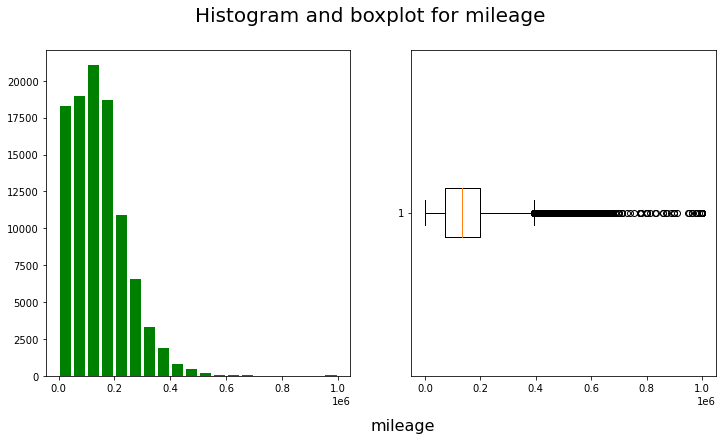

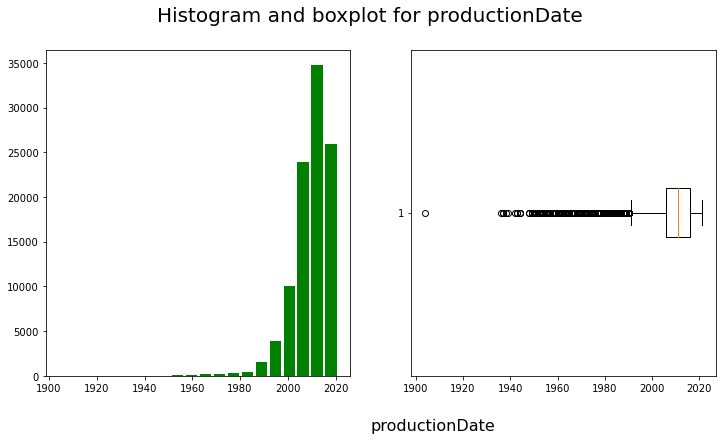

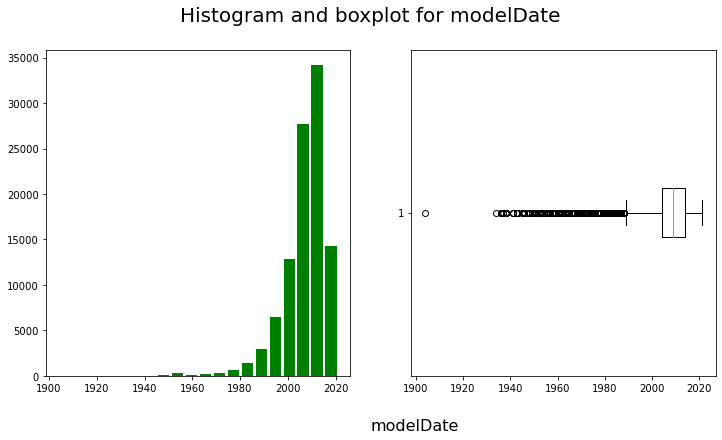

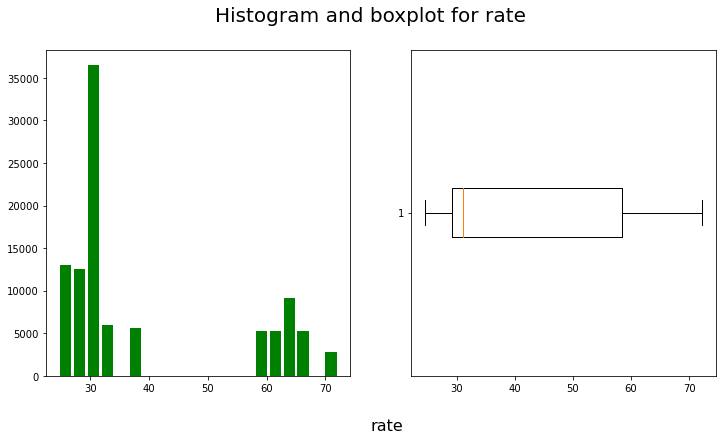

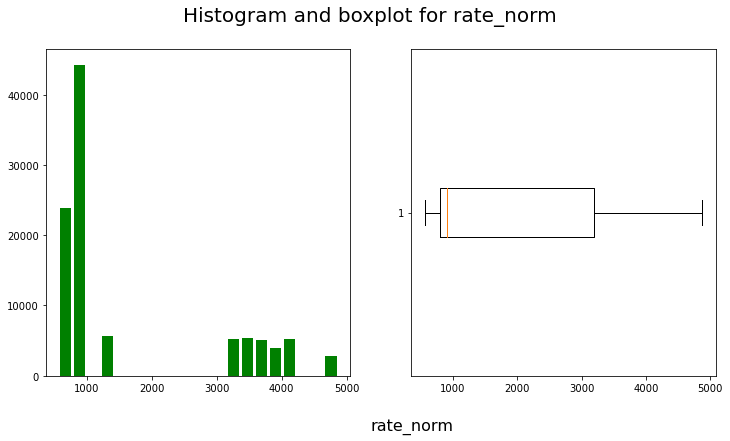

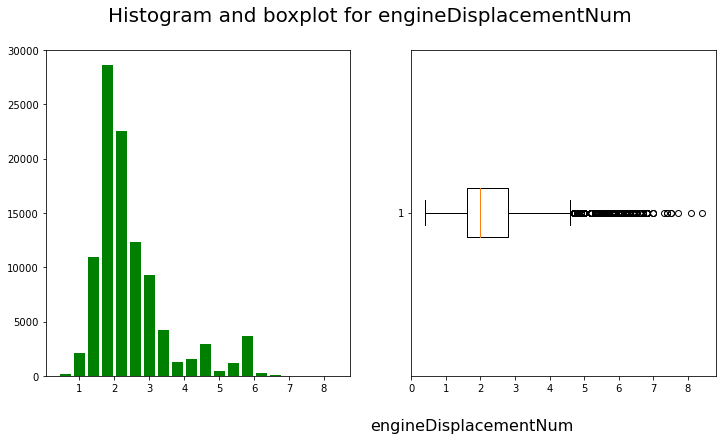

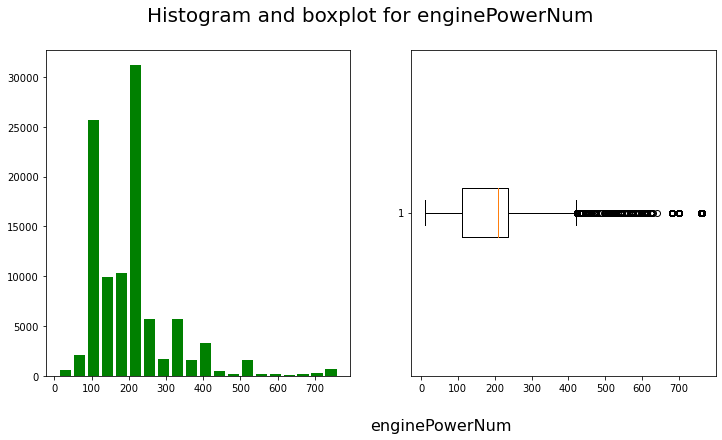

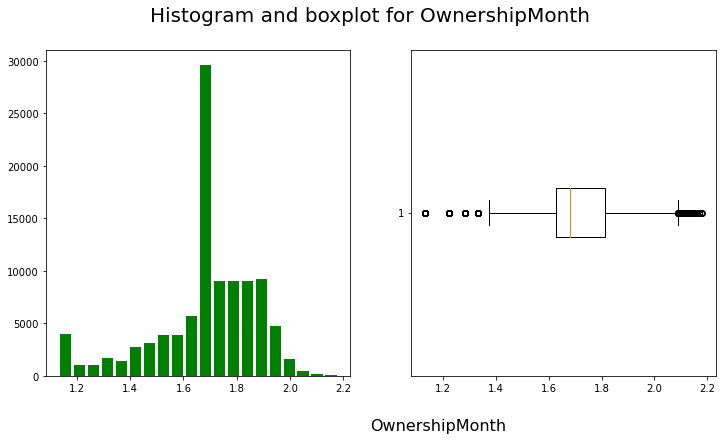

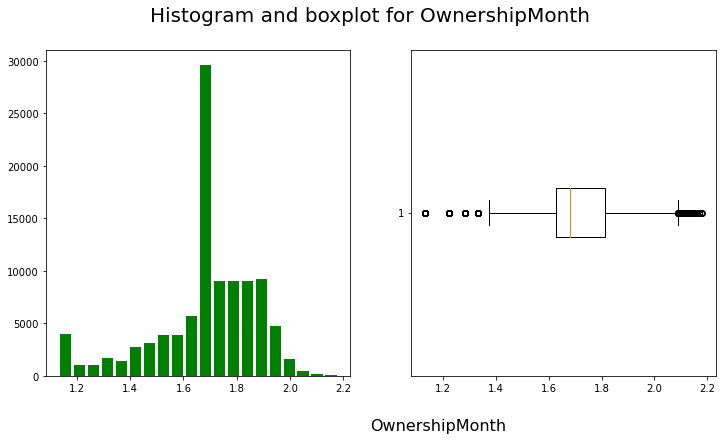

In [598]:
for col in(num_columns):
    graph_num(col, data)

In [599]:
for col in num_columns:
    statistic(col, data)

Для mileage IQR: 128594.75,  Границы выбросов: [-121486.875, 392892.125].
Всего 2089 выбросов
Для productionDate IQR: 10.0,  Границы выбросов: [1991.0, 2031.0].
Всего 2381 выбросов
Для modelDate IQR: 10.0,  Границы выбросов: [1989.0, 2029.0].
Всего 4320 выбросов
Для rate IQR: 29.18,  Границы выбросов: [-14.599999999999994, 102.12].
Всего 0 выбросов
Для rate_norm IQR: 2388.753233231075,  Границы выбросов: [-2787.2425958785257, 6767.770337045773].
Всего 0 выбросов
Для engineDisplacementNum IQR: 1.1999999999999997,  Границы выбросов: [-0.1999999999999995, 4.6].
Всего 6683 выбросов
Для enginePowerNum IQR: 124.0,  Границы выбросов: [-75.0, 421.0].
Всего 5606 выбросов
Для OwnershipMonth IQR: 0.18524455296758569,  Границы выбросов: [1.3496157843376695, 2.0905939962080122].
Всего 7966 выбросов
Для OwnershipMonth IQR: 0.18524455296758569,  Границы выбросов: [1.3496157843376695, 2.0905939962080122].
Всего 7966 выбросов


In [600]:
# Не смотря на то, что выбросы есть, и где-то значительные, в полном смысле выбросами это назвать нельзя.
# Вероятно поэтому, почти любые попытки их почистить приводят к ухудшению модели. 

In [601]:
# Распределение почти нокмальное, со смещением. Попробуем прологарифмировать

#for i in num_columns:
#    data[i] = np.log(data[i]+1)

In [603]:
# Нормализация данных
scaler = StandardScaler()
#scaler = MinMaxScaler()
for column in num_columns:
    data[column] = scaler.fit_transform(data[[column]])[:,0]

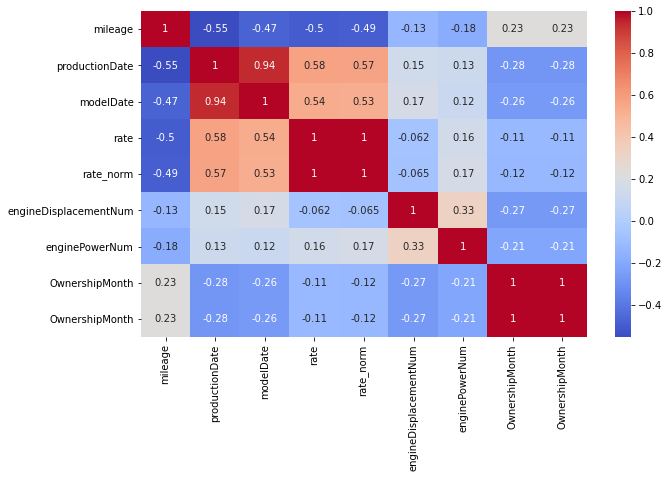

In [604]:
# Посмотрим корреляцию числовых признаков
correlation = data[num_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [605]:
data.rate

0        -0.047486
1         1.248043
2        -0.047486
3        -0.047486
4        -0.523965
            ...   
101401   -0.523965
101402   -0.523965
101403   -0.523965
101404   -0.523965
101405   -0.523965
Name: rate, Length: 101406, dtype: float64

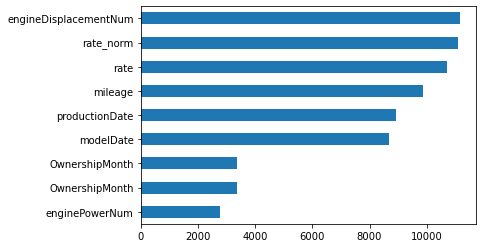

In [606]:
# Значимость числовых признаков
imp_num = pd.Series(f_regression(data[data['sample'] == 1][num_columns],
                              data[data['sample'] == 1].price)[0], index = num_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Label Encoding

In [607]:
# реализуем метод OneHotLabels через get_dummies для категориальных признаков

data = pd.get_dummies(data, prefix=cat_columns, columns=cat_columns)

In [608]:
for colum in ['enginePower', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [609]:
#del_columns.append('enginePower')
#del_columns.append('engineDisplacement')

In [610]:
# Создаем признаки с мнимыми переменными на основе параметра 'equipment_dict_list'
dummies = pd.get_dummies(data1['equipment_dict_list']).rename(columns=lambda x: str(x))
df1 = pd.concat([data1, dummies], axis=1)
df2 = pd.DataFrame()
#Составим общий список всех опций. Обеспечим уникальность через использование множеств
equipment_list = set()
for item in data1['equipment_dict_list']:
#    for i in item:
        equipment_list.add(item)
 #   equipment_list.add(i)

for i in equipment_list:
     df2[i] = df1.groupby(['idx_df'])[i].sum()[:]

data = pd.merge(data, df2, on = 'idx_df')

del_columns.append('equipment_dict_list')

In [611]:
data.head(2)

,idx_df,car_url,complectation_dict,engineDisplacement,enginePower,equipment_dict,mileage,model_info,productionDate,super_gen,Владельцы,Владение,modelDate,sample,price,rate,rate_norm,engineDisplacementNum,enginePowerNum,equipment_dict_list,OwnershipMonth,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_микровэн,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_пикап одинарная кабина,bodyType_пикап полуторная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_седан-хардтоп,bodyType_спидстер,bodyType_тарга,bodyType_универсал 3 дв.,bodyType_универсал 5 дв.,bodyType_фастбек,bodyType_фургон,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 4 дв.,bodyType_хэтчбек 5 дв.,brand_AC,brand_ACURA,brand_ALFA,brand_ALPINA,brand_AMC,brand_ARIEL,brand_ARO,brand_ASIA,brand_ASTON,brand_AUDI,brand_BENTLEY,brand_BMW,brand_BRABUS,brand_BRILLIANCE,brand_BUICK,brand_BYD,brand_CADILLAC,brand_CHANGAN,brand_CHERY,brand_CHERYEXEED,brand_CHEVROLET,brand_CHRYSLER,brand_CITROEN,brand_DACIA,brand_DADI,brand_DAEWOO,brand_DAIHATSU,brand_DAIMLER,brand_DATSUN,brand_DERWAYS,brand_DKW,brand_DODGE,brand_DONGFENG,brand_DONINVEST,brand_DS,brand_DW,brand_EAGLE,brand_FAW,brand_FERRARI,brand_FIAT,brand_FISKER,brand_FORD,brand_FOTON,brand_GAC,brand_GEELY,brand_GENESIS,brand_GEO,brand_GMC,brand_GREAT,brand_HAFEI,brand_HAIMA,brand_HAVAL,brand_HAWTAI,brand_HONDA,brand_HUMMER,brand_HYUNDAI,brand_INFINITI,brand_IRAN,brand_ISUZU,brand_JAC,brand_JAGUAR,brand_JEEP,brand_KIA,brand_LADA,brand_LAMBORGHINI,brand_LANCIA,brand_LAND,brand_LEXUS,brand_LIFAN,brand_LIGIER,brand_LINCOLN,brand_LOTUS,brand_LTI,brand_LUXGEN,brand_MAHINDRA,brand_MASERATI,brand_MAYBACH,brand_MAZDA,brand_MCLAREN,brand_MERCEDES,brand_MERCEDES-BENZ,brand_MERCURY,brand_METROCAB,brand_MG,brand_MINI,brand_MITSUBISHI,brand_NISSAN,brand_OLDSMOBILE,brand_OPEL,brand_PACKARD,brand_PEUGEOT,brand_PLYMOUTH,brand_PONTIAC,brand_PORSCHE,brand_PROTON,brand_RAM,brand_RAVON,brand_RENAULT,brand_ROLLS-ROYCE,brand_ROVER,brand_SAAB,brand_SATURN,brand_SCION,brand_SEAT,brand_SHANGHAI,brand_SKODA,brand_SMART,brand_SSANGYONG,brand_SUBARU,brand_SUZUKI,brand_TATRA,brand_TESLA,brand_TIANMA,brand_TIANYE,brand_TOYOTA,brand_TRABANT,brand_TRIUMPH,brand_VOLKSWAGEN,brand_VOLVO,brand_VORTEX,brand_WARTBURG,brand_WILLYS,brand_XIN,brand_ZIBAR,brand_ZOTYE,brand_ZX,brand_ГАЗ,brand_ЗАЗ,brand_ЗИЛ,brand_ЗИС,brand_ИЖ,brand_ЛУАЗ,brand_МОСКВИЧ,brand_СМЗ,brand_СПОРТИВНЫЕ,brand_ТАГАЗ,brand_УАЗ,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_ бензин,"fuelType_ бензин, газобаллонное оборудование",fuelType_ газ,"fuelType_ газ, газобаллонное оборудование",fuelType_ гибрид,fuelType_ дизель,"fuelType_ дизель, газобаллонное оборудование",fuelType_ электро,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,model_name_02,model_name_100,model_name_1007,model_name_100NX,model_name_100_SERIES,model_name_106,model_name_107,model_name_110,model_name_1111,model_name_114,model_name_12,model_name_120,model_name_1200,model_name_121,model_name_13,model_name_1302,model_name_14,model_name_140,model_name_145,model_name_146,model_name_147,model_name_1500,model_name_156,model_name_159,model_name_166,model_name_180SX,model_name_19,model_name_190_SL,model_name_1ER,model_name_1_3,model_name_2,model_name_20,model_name_200,model_name_2000_C_CS,model_name_2008,model_name_200SX,model_name_205,model_name_206,model_name_207,model_name_208,model_name_21,model_name_2101,model_name_2102,model_name_2103,model_name_2104,model_name_2105,model_name_2106,model_name_2107,model_name_2108,model_name_2109,model_name_21099,model_name_2110,model_name_2111,model_name_2112,model_name_2113,model_name_2114,model_name_2115,model_nam

In [612]:
data = data.sort_values(by = 'idx_df')

# Удаление столбцов

In [613]:
del_columns

['equipment_dict',
 'model_info',
 'super_gen',
 'car_url',
 'complectation_dict',
 'Владение',
 'Владение',
 'equipment_dict_list']

In [614]:
data.drop((del_columns), axis=1, inplace=True )
data.drop('idx_df', axis=1, inplace=True )


In [617]:
y = data.query('sample == 1')['price']
X = data.query('sample == 1').drop(['sample'], axis=1)
X = X.drop(['price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)
X_sub = X_sub.drop(['price'], axis=1)

## Train Split

In [618]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# **Простые модели**

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [619]:
def print_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность модели по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

In [620]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [621]:
start = datetime.now()
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print_report(start, y_test, predict)


Время выполнения -  0:00:00.006707
Точность модели по метрике MAPE:105.29%


# Model 2 : CatBoost

У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [449]:
start = datetime.now()
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2CB_baseline.model')

In [450]:
# оцениваем точность
predict = model.predict(X_test)
print_report(start, y_test, predict)


Время выполнения -  0:02:02.051593
Точность модели по метрике MAPE:25.19%


### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [451]:
#np.log(y_train)

In [453]:
start = datetime.now()
model = CatBoostRegressor(iterations = 4500,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,)

model.save_model('catboost_single_model_3_baseline.model')

In [454]:
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))
print_report(start, y_test, predict_test)


Время выполнения -  0:01:51.190581
Точность модели по метрике MAPE:17.20%


# Model 3 : Random Forest

In [455]:
start = datetime.now()
# Поиск наилучших параметров. Закомментирован для экономии времени
'''random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rfr = RandomForestRegressor(bootstrap=False, max_features='sqrt',
                      min_samples_split=10, n_estimators=300, random_state=42)
                      rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid,
                      n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
rf_random.fit(X_train, np.log(y_train))
rf_random.best_params_'''

"random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],\n               'max_features': ['auto', 'sqrt'],\n               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],\n               'min_samples_split': [2, 5, 10],\n               'min_samples_leaf': [1, 2, 4],\n               'bootstrap': [True, False]}\n\nrfr = RandomForestRegressor(bootstrap=False, max_features='sqrt',\n                      min_samples_split=10, n_estimators=300, random_state=42)\n                      rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid,\n                      n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)\nrf_random.fit(X_train, np.log(y_train))\nrf_random.best_params_"

In [456]:
#rf_random.best_params_

In [457]:
#best_rfr = rf_random.best_estimator_

In [458]:
'''best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='auto'
                      , max_depth=None
                      , bootstrap=False
                      , n_jobs=-1)

best_rfr.fit(X_train, np.log(y_train))


predict_rfr = np.exp(best_rfr.predict(X_test))
print_report(start, y_test, predict_rfr)'''

#Время выполнения -  0:17:37.642517
#Точность модели по метрике MAPE:25.96%

"best_rfr = RandomForestRegressor(random_state=RANDOM_SEED\n                      , n_estimators=200\n                      , min_samples_split=2\n                      , min_samples_leaf=2\n                      , max_features='auto'\n                      , max_depth=None\n                      , bootstrap=False\n                      , n_jobs=-1)\n\nbest_rfr.fit(X_train, np.log(y_train))\n\n\npredict_rfr = np.exp(best_rfr.predict(X_test))\nprint_report(start, y_test, predict_rfr)"

In [459]:
#model = best_rfr

In [460]:
#predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

In [461]:
type(sample_submission['price'][8])

numpy.int64

# Model 4: Gradient Boosting

In [462]:
'''start = datetime.now()

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}'''

"start = datetime.now()\n\nrandom_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],\n               'max_features': ['auto', 'sqrt', 'log2'],\n               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],\n               'min_samples_split': [2, 5, 10],\n               'min_samples_leaf': [1, 2, 4]}"

In [463]:
# Поиск наилучших параметров. Закомментирован для экономии времени
'''gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid, n_iter = 100,
                                cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
gbr_random.fit(X_train, np.log(y_train))
gbr_random.best_params_'''

'gbr = GradientBoostingRegressor()\ngbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid, n_iter = 100,\n                                cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)\ngbr_random.fit(X_train, np.log(y_train))\ngbr_random.best_params_'

In [465]:
best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED
                      , n_estimators=314
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='auto'
                      , max_depth=5)

In [466]:
X_sub.rate.isna().sum()

0

In [467]:
best_gbr.fit(X_train, np.log(y_train))

predict_gbr = np.exp(best_gbr.predict(X_test))
print_report(start, y_test, predict_gbr)


Время выполнения -  0:12:34.641251
Точность модели по метрике MAPE:19.54%


# Model 5: XGB

In [629]:
'''start = datetime.now()

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1, n_jobs=-1,
                          n_estimators=1000)
xgb_reg.fit(X_train, np.log(y_train))
xgb_red_pred = np.exp(xgb_reg.predict(X_test))
print_report(start, y_test, xgb_red_pred)'''

"start = datetime.now()\n\nxgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,\n                          learning_rate=0.05, max_depth=12, alpha=1, n_jobs=-1,\n                          n_estimators=1000)\nxgb_reg.fit(X_train, np.log(y_train))\nxgb_red_pred = np.exp(xgb_reg.predict(X_test))\nprint_report(start, y_test, xgb_red_pred)"

# Выводы
Всего были опробованы следующие модели:

- Linear Regression
- Random Forest Regressor
- Decision Tree Regressor
- AdaBoost
- XGBoost
- CatBoost
- GradientBoosting

Лучшие результаты получены с CatBoost, XGBoost и GradientBoosting

# **Ансамбли**

# Model 6: Bagging

In [ ]:
# Bagging с Random Forest регрессором
'''start = datetime.now()

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_report(start, y_test, predict_bagg_rfr)'''

# Время выполнения -  0:35:26.661721
# Точность модели по метрике MAPE:21.69%

In [ ]:
# Bagging с Gradient Boosting Regressor
'''start = datetime.now()

bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
bagg_gbr.fit(X_train, np.log(y_train))
predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))
print_report(start, y_test, predict_bagg_gbr)'''

# Время выполнения -  0:21:17.588537
# Точность модели по метрике MAPE:19.59%

In [ ]:
# Bagging с XGB регрессором
start = datetime.now()

bagg_xgb = BaggingRegressor(xgb_reg, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
bagg_xgb.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
print_report(start, y_test, predict_bagg_xgb)

In [ ]:
len(X_test)

# Model 7: Stacking

In [ ]:
'''start = datetime.now()
estimators = [
    ('cat_boost', CatBoostRegressor(random_seed=RANDOM_SEED,
                                    eval_metric='MAPE',
                                    iterations=4500,
                                    l2_leaf_reg=4,
                                    depth=7,
                                    custom_metric=['MAE'],
                                    loss_function='RMSE',
                                    learning_rate=0.08,
                                    verbose=1)
    )
    ('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED
                                                                ,n_estimators=314
                                                                ,min_samples_split=2
                                                                ,min_samples_leaf=2
                                                                ,max_features='auto'
                                                                ,max_depth=5)
                                                                ,n_estimators=3
                                                                ,n_jobs=-1
                                                                ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.03
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000))
]

stack_ensemble = StackingRegressor(
    estimators=estimators,
    verbose=10,
    passthrough=True,
    n_jobs=-1,
    final_estimator=CatBoostRegressor(random_seed=RANDOM_SEED,
                                    eval_metric='MAPE',
                                    iterations=4500,
                                    l2_leaf_reg=4,
                                    depth=7,
                                    custom_metric=['MAE'],
                                    loss_function='RMSE',
                                    learning_rate=0.08,
                                    verbose=1)
)

stack_ensemble.fit(X_train, np.log(y_train))
y_pred = np.exp(stack_ensemble.predict(X_test))

print_report(start, y_test, y_pred)'''

# Время выполнения -  1:39:02.674098
# Точность модели по метрике MAPE:16.86%

In [ ]:
'''start = datetime.now()

estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED
                                                                ,n_estimators=314
                                                                ,min_samples_split=2
                                                                ,min_samples_leaf=2
                                                                ,max_features='auto'
                                                                ,max_depth=5)
                                                                ,n_estimators=3
                                                                ,n_jobs=-1
                                                                ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.03
                                      ,max_depth=11
                                      ,alpha=1
                                      ,n_estimators=1200))]

st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = cat_boost.CatBoostRegressor(iterations = 4500
                                                                     ,random_seed = RANDOM_SEED
                                                                     ,eval_metric='MAPE'
                                                                     ,custom_metric=['MAE']
                                                                     ,silent=True
                                                                     ,learning_rate=0.11
                                                                     ,depth=11
                                                                     ,l2_leaf_reg=7
                                                                     ,random_strength=0.2))

    
st_ensemble.fit(X_train, np.log(y_train))

predict_submission = np.exp(st_ensemble.predict(X_test))
print_report(start, y_test, predict_submission)'''

# Время выполнения -  1:20:31.765489
# Точность модели по метрике MAPE:17.11%

In [471]:
start = datetime.now()
estimators = [
    ('cat_boost', CatBoostRegressor(random_seed=RANDOM_SEED,
                                    eval_metric='MAPE',
                                    iterations=4500,
                                    l2_leaf_reg=4,
                                    depth=7,
                                    custom_metric=['MAE'],
                                    loss_function='RMSE',
                                    learning_rate=0.08,
                                    verbose=1)
    )
    '''('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED
                                                                ,n_estimators=314
                                                                ,min_samples_split=2
                                                                ,min_samples_leaf=2
                                                                ,max_features='auto'
                                                                ,max_depth=5)
                                                                ,n_estimators=3
                                                                ,n_jobs=-1
                                                                ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.03
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000))'''
]

stack_ensemble = StackingRegressor(
    estimators=estimators,
    verbose=10,
    passthrough=True,
    n_jobs=-1,
    final_estimator=xgb.XGBRegressor(objective='reg:squarederror',
                                     colsample_bytree=0.5,
                                     learning_rate=0.03,
                                     max_depth=11,
                                     alpha=1,
                                     n_jobs=-1,
                                     n_estimators=1000,
                                     seed=RANDOM_SEED)
)

stack_ensemble.fit(X_train, np.log(y_train))
y_pred = np.exp(stack_ensemble.predict(X_test))

print_report(start, y_test, y_pred)

# Время выполнения -  1:17:36.156442
# Точность модели по метрике MAPE:16.61%


Время выполнения -  1:17:36.156442
Точность модели по метрике MAPE:16.61%


# Submission

In [626]:
X_sub.head(3)

,engineDisplacement,enginePower,mileage,productionDate,Владельцы,modelDate,rate,rate_norm,engineDisplacementNum,enginePowerNum,OwnershipMonth,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_микровэн,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_пикап одинарная кабина,bodyType_пикап полуторная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_седан-хардтоп,bodyType_спидстер,bodyType_тарга,bodyType_универсал 3 дв.,bodyType_универсал 5 дв.,bodyType_фастбек,bodyType_фургон,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 4 дв.,bodyType_хэтчбек 5 дв.,brand_AC,brand_ACURA,brand_ALFA,brand_ALPINA,brand_AMC,brand_ARIEL,brand_ARO,brand_ASIA,brand_ASTON,brand_AUDI,brand_BENTLEY,brand_BMW,brand_BRABUS,brand_BRILLIANCE,brand_BUICK,brand_BYD,brand_CADILLAC,brand_CHANGAN,brand_CHERY,brand_CHERYEXEED,brand_CHEVROLET,brand_CHRYSLER,brand_CITROEN,brand_DACIA,brand_DADI,brand_DAEWOO,brand_DAIHATSU,brand_DAIMLER,brand_DATSUN,brand_DERWAYS,brand_DKW,brand_DODGE,brand_DONGFENG,brand_DONINVEST,brand_DS,brand_DW,brand_EAGLE,brand_FAW,brand_FERRARI,brand_FIAT,brand_FISKER,brand_FORD,brand_FOTON,brand_GAC,brand_GEELY,brand_GENESIS,brand_GEO,brand_GMC,brand_GREAT,brand_HAFEI,brand_HAIMA,brand_HAVAL,brand_HAWTAI,brand_HONDA,brand_HUMMER,brand_HYUNDAI,brand_INFINITI,brand_IRAN,brand_ISUZU,brand_JAC,brand_JAGUAR,brand_JEEP,brand_KIA,brand_LADA,brand_LAMBORGHINI,brand_LANCIA,brand_LAND,brand_LEXUS,brand_LIFAN,brand_LIGIER,brand_LINCOLN,brand_LOTUS,brand_LTI,brand_LUXGEN,brand_MAHINDRA,brand_MASERATI,brand_MAYBACH,brand_MAZDA,brand_MCLAREN,brand_MERCEDES,brand_MERCEDES-BENZ,brand_MERCURY,brand_METROCAB,brand_MG,brand_MINI,brand_MITSUBISHI,brand_NISSAN,brand_OLDSMOBILE,brand_OPEL,brand_PACKARD,brand_PEUGEOT,brand_PLYMOUTH,brand_PONTIAC,brand_PORSCHE,brand_PROTON,brand_RAM,brand_RAVON,brand_RENAULT,brand_ROLLS-ROYCE,brand_ROVER,brand_SAAB,brand_SATURN,brand_SCION,brand_SEAT,brand_SHANGHAI,brand_SKODA,brand_SMART,brand_SSANGYONG,brand_SUBARU,brand_SUZUKI,brand_TATRA,brand_TESLA,brand_TIANMA,brand_TIANYE,brand_TOYOTA,brand_TRABANT,brand_TRIUMPH,brand_VOLKSWAGEN,brand_VOLVO,brand_VORTEX,brand_WARTBURG,brand_WILLYS,brand_XIN,brand_ZIBAR,brand_ZOTYE,brand_ZX,brand_ГАЗ,brand_ЗАЗ,brand_ЗИЛ,brand_ЗИС,brand_ИЖ,brand_ЛУАЗ,brand_МОСКВИЧ,brand_СМЗ,brand_СПОРТИВНЫЕ,brand_ТАГАЗ,brand_УАЗ,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_ бензин,"fuelType_ бензин, газобаллонное оборудование",fuelType_ газ,"fuelType_ газ, газобаллонное оборудование",fuelType_ гибрид,fuelType_ дизель,"fuelType_ дизель, газобаллонное оборудование",fuelType_ электро,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,model_name_02,model_name_100,model_name_1007,model_name_100NX,model_name_100_SERIES,model_name_106,model_name_107,model_name_110,model_name_1111,model_name_114,model_name_12,model_name_120,model_name_1200,model_name_121,model_name_13,model_name_1302,model_name_14,model_name_140,model_name_145,model_name_146,model_name_147,model_name_1500,model_name_156,model_name_159,model_name_166,model_name_180SX,model_name_19,model_name_190_SL,model_name_1ER,model_name_1_3,model_name_2,model_name_20,model_name_200,model_name_2000_C_CS,model_name_2008,model_name_200SX,model_name_205,model_name_206,model_name_207,model_name_208,model_name_21,model_name_2101,model_name_2102,model_name_2103,model_name_2104,model_name_2105,model_name_2106,model_name_2107,model_name_2108,model_name_2109,model_name_21099,model_name_2110,model_name_2111,model_name_2112,model_name_2113,model_name_2114,model_name_2115,model_name_2120,model_name_2121,model_name_2125,model_name_2126,model_name_21261_FABULA,model_name_2131_4X4,model_name_21

In [627]:
#X_sub = scaler.transform(X_sub)
predict_submission = np.exp(stack_ensemble.predict(X_sub))*0.95125

In [628]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('sample_submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,3.273567e+05
1,1100549428,4.985595e+05
2,1100658222,6.841041e+05
3,1100937408,2.269212e+05
4,1101037972,1.131535e+06
5,1100912634,2.747282e+05
6,1101228730,1.045513e+06
7,1100165896,1.918938e+05
8,1100768262,1.102626e+06
9,1101218501,6.166894e+05


# Итоги и содержание работы
- Проведен парсинг свежих данных с auto.ru
- Произведен разведывательный анализ данных
- Были созданы новые признаки
- Была попытка учесть разницу в ценах на момент создания тестовой выборки.
- Были подготовлены данные для использования в моделях машинного обучения
- Проведены тестовые обучения на различных моделях
- Подобраны оптимальные гиперпараметры для моделей
- Был произведен экспериментальный подбор моделей для ансамблей Бэггинга и Стэкинга
- Результаты загружены на Kaggle и GitHub


# Выводы
- наилучшие результаты на наших данных показали модели CatBoost, GradientBoosting, XGBoost и ансамбли с их использованием

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing